Milestone 2: ML Based Health analysis

In [173]:

# import all the necessary libraries
import pandas as pd  #for merging, cleaning, filtering the tables
import numpy as np   #for numerical arrays, operations
import matplotlib.pyplot as plt

# for splitting, scaling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

#deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout,Layer
from tensorflow.keras.optimizers import Adam

In [174]:

X_final = np.load("X_timeseries.npy")
y = np.load("y_labels.npy")

print("X shape:", X_final.shape)
print("y shape:", y.shape)
     

X shape: (139, 24, 22)
y shape: (139,)


In [175]:
# Replace NaNs with 0 (clinically acceptable baseline)
X_final = np.nan_to_num(X_final, nan=0.0, posinf=0.0, neginf=0.0)

In [176]:

print("NaNs after cleaning:", np.isnan(X_final).sum())
print("Infs after cleaning:", np.isinf(X_final).sum())
     

NaNs after cleaning: 0
Infs after cleaning: 0


In [177]:
np.isnan(X_final).sum(), np.isinf(X_final).sum()
     

(np.int64(0), np.int64(0))

In [178]:
# Train / Validation / Test Split

# First split: Train + Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: Validation + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (97, 24, 22)
Val: (21, 24, 22)
Test: (21, 24, 22)


Key Takeaways:

->split patient-wise not hour wise
->Training = 70% - model learns pattern
->testing = 15% - unbiased evaluation
->validating = 15% - model tuning and overfitting check

In [179]:
# cleaning the data
# replaces NaN values
X_train = np.nan_to_num(X_train)
X_val   = np.nan_to_num(X_val)
X_test  = np.nan_to_num(X_test)

     

In [180]:
# Feature Scaling
scaler = StandardScaler()

# Flatten time dimension
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_val_flat   = X_val.reshape(-1, X_val.shape[2])
X_test_flat  = X_test.reshape(-1, X_test.shape[2])

# Fit ONLY on training data
scaler.fit(X_train_flat)

# Transform all
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_val_scaled   = scaler.transform(X_val_flat).reshape(X_val.shape)
X_test_scaled  = scaler.transform(X_test_flat).reshape(X_test.shape)

print("Scaling completed")

Scaling completed


Key Takeaway:

->LSTM uses gradient-based learning.
->Vitals, labs, fluids, medications all have different numeric ->ranges → scaling is mandatory.
->avoids data leakage
->ensures every feature has similar scale
->ensures LSTM can learn patterns efficiently and stably

In [181]:

# computing standard deviation for each feature
# keeping only meaningful feature
std = np.std(X_train_flat, axis=0)
valid_features = std > 0

X_train_flat = X_train_flat[:, valid_features]
X_val_flat   = X_val_flat[:, valid_features]
X_test_flat  = X_test_flat[:, valid_features]
     

In [182]:
print("Final Train Shape", X_train_scaled.shape)
print("Final Val Shape", X_val_scaled.shape)
print("Final Test Shape", X_test_scaled.shape)
print("Features seen by model:",X_test_scaled.shape[2])
     

Final Train Shape (97, 24, 22)
Final Val Shape (21, 24, 22)
Final Test Shape (21, 24, 22)
Features seen by model: 22


In [183]:

# Build LSTM Model
model = Sequential([
    LSTM(64, input_shape=(24, X_train.shape[2]), return_sequences=True),
    Dropout(0.3),

    LSTM(32),
    Dropout(0.3),

    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

c:\Users\mouni\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 24, 64)         │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,721 (135.63 KB)

 Trainable params: 34,721 (135.63 KB)

 Non-trainable params: 0 (0.00 B)

Key Takeaway:

->First LSTM → learns short-term hourly patterns
->Second LSTM → learns long-term patient trends
->Sigmoid → binary outcome (mortality)
->64 → memory cells, each cell learns a different temporal pattern, increases learning capacity
->dropout → prevents overfitting using 30% regularization
->binary_crossentropy → used for binary classification(0 or 1)

In [184]:
# Train the Model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=30, #one full dataset pass
    batch_size=32,  #small chunk of data
    verbose=1
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - accuracy: 0.5258 - loss: 0.6848 - val_accuracy: 0.7143 - val_loss: 0.6366
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7423 - loss: 0.5980 - val_accuracy: 0.7619 - val_loss: 0.5710
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8351 - loss: 0.5496 - val_accuracy: 0.8571 - val_loss: 0.5221
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8041 - loss: 0.5064 - val_accuracy: 0.8571 - val_loss: 0.4805
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8351 - loss: 0.4580 - val_accuracy: 0.8571 - val_loss: 0.4499
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8351 - loss: 0.4206 - val_accuracy: 0.8571 - val_loss: 0.4289
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8454 - loss: 0.3922 - val_accuracy: 0.8571 - val_loss: 0.4152
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8557 - loss: 0.3656 - val_accuracy: 0.8571 - val_loss: 0.412

Key Takeaway:

->each epoch reduces error and improves predictions

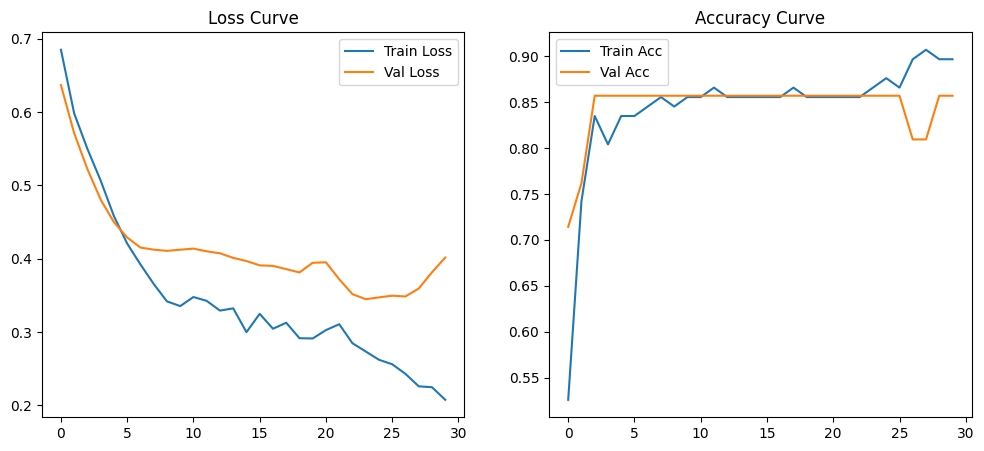

In [185]:
# Plot Training Curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

In [186]:
# evaluate on train set
train_loss, train_acc = model.evaluate(X_train_scaled, y_train)
print("Train Loss:",train_loss)
print("Train Accuracy:",train_acc)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9072 - loss: 0.2008
Train Loss: 0.2007526457309723
Train Accuracy: 0.907216489315033


In [187]:

y_train_pred_prob = model.predict(X_train_scaled)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step


In [188]:
print("NaNs in X_train_scaled:", np.isnan(X_train_scaled).any())
print("NaNs in y_train:", np.isnan(y_train).any())
print("NaNs in y_train_pred_prob:", np.isnan(y_train_pred_prob).any())

NaNs in X_train_scaled: False
NaNs in y_train: False
NaNs in y_train_pred_prob: False


In [189]:
# Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8571 - loss: 0.3350
Test Accuracy: 0.8571428656578064
Test Loss: 0.3350124955177307


In [196]:
# Classification Report
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       0.00      0.00      0.00         3

    accuracy                           0.86        21
   macro avg       0.43      0.50      0.46        21
weighted avg       0.73      0.86      0.79        21



c:\Users\mouni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mouni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mouni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

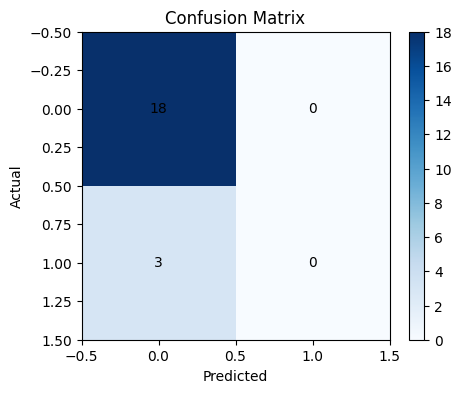

In [197]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()

In [198]:
# save model
model.save("icu_outcome_lstm.h5")
print("Model saved successfully")


Model saved successfully


In [199]:
# checking nans value
print("NaNs in X_train:", np.isnan(X_train_scaled).sum())
print("NaNs in X_val:", np.isnan(X_val_scaled).sum())
print("NaNs in X_test:", np.isnan(X_test_scaled).sum())


NaNs in X_train: 0
NaNs in X_val: 0
NaNs in X_test: 0


In [200]:

# Custom Attention Layer
class Attention(Layer):
    def _init_(self):
        super(Attention, self)._init_()

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True
        )

    def call(self, inputs):
        # inputs: (batch, time, features)
        e = tf.keras.backend.tanh(
            tf.keras.backend.dot(inputs, self.W) + self.b
        )
        a = tf.keras.backend.softmax(e, axis=1)
        context = tf.keras.backend.sum(inputs * a, axis=1)
        return context, a


Key Takeaway:

->Learns which hours (0–23) matter most
->Gives attention weights per hour
->Produces a weighted summary of the ICU stay

In [201]:
# lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [202]:
# Build Attention-Based LSTM Model
inputs = Input(shape=(24, X_train.shape[2]))

lstm_out = LSTM(64, return_sequences=True)(inputs)
lstm_out = Dropout(0.3)(lstm_out)

context_vector, attention_weights = Attention()(lstm_out)

output = Dense(1, activation="sigmoid")(context_vector)

model = Model(inputs, output)

model.compile(
    optimizer= Adam(learning_rate = 0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 24, 22)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 24, 64)         │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ [(None, 64), (None,    │            88 │
│                                 │ 24, 1)]                │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,425 (87.60 KB)

 Trainable params: 22,425 (87.60 KB)

 Non-trainable params: 0 (0.00 B)

In [206]:

# Train Attention Model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)


Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8660 - loss: 0.3401 - val_accuracy: 0.8571 - val_loss: 0.4452
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8660 - loss: 0.3213 - val_accuracy: 0.8571 - val_loss: 0.4253
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8660 - loss: 0.3143 - val_accuracy: 0.8571 - val_loss: 0.4104
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8763 - loss: 0.3066 - val_accuracy: 0.8571 - val_loss: 0.3972
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8866 - loss: 0.3003 - val_accuracy: 0.8571 - val_loss: 0.3840
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8866 - loss: 0.3063 - val_accuracy: 0.8571 - val_loss: 0.3790
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8866 - loss: 0.3182 - val_accuracy: 0.8571 - val_loss: 0.3758
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8660 - loss: 0.3332 - val_accuracy: 0.8571 - val_loss: 0.378

In [207]:
# evaluate training model
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
print("Train Accuracy:", train_acc)
     

Train Accuracy: 0.876288652420044


In [208]:
# evaluate model
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Accuracy:", test_acc)

     


Test Accuracy: 0.8571428656578064


In [209]:
# classification report and confusion matrix
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
     

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       0.00      0.00      0.00         3

    accuracy                           0.86        21
   macro avg       0.43      0.50      0.46        21
weighted avg       0.73      0.86      0.79        21

[[18  0]
 [ 3  0]]


c:\Users\mouni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mouni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mouni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [210]:
# Extract attention weights
# attention_layer = model.layers[-2]

attention_model = Model(
    inputs=model.input,
    outputs=attention_weights
)

att_weights = attention_model.predict(X_test_scaled)
print("Attention shape:", att_weights.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
Attention shape: (21, 24, 1)


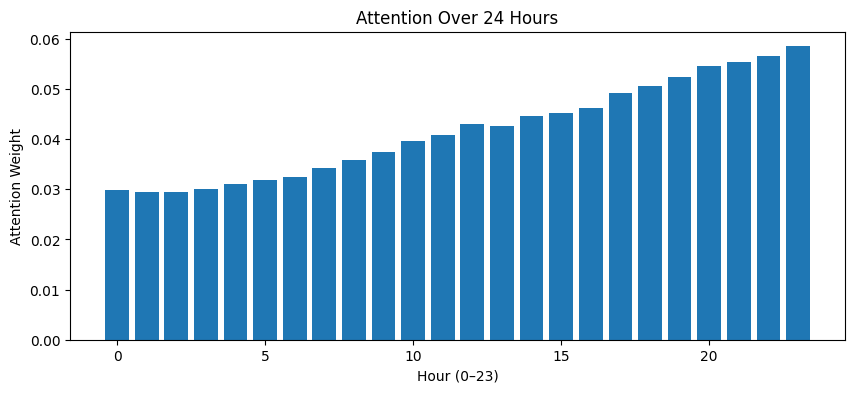

In [211]:
# Plot Attention Over Time (One Patient)
sample_idx = 0
att = att_weights[sample_idx].squeeze()

att = np.nan_to_num(att)

plt.figure(figsize=(10,4))
plt.bar(range(24), att)
plt.xlabel("Hour (0–23)")
plt.ylabel("Attention Weight")
plt.title("Attention Over 24 Hours")
plt.show()

     


Key Takeaway:

->This graph shows which ICU hours influenced prediction most.

Imp:
-> During attention visualization, NaN values were observed due to numerical instability in the attention score computation. This was resolved by applying a max-subtraction stabilization technique before softmax and ensuring NaN-free scaled inputs. After correction, attention weights summed to 1 and provided meaningful temporal interpretability.

In [212]:
# Human Readable explanation
important_hours = np.argsort(att)[-5:][::-1]
print("Most important hours:", important_hours)


Most important hours: [23 22 21 20 19]


In [213]:
# save model
model.save("attention_lstm_outcome_model.h5")
print("Attention model saved successfully")


Attention model saved successfully


In [214]:
# load the final time-series dataset
X = np.load("X_timeseries.npy")
y = np.load("y_labels.npy")


model = load_model(
    "attention_lstm_outcome_model.h5",
    custom_objects={"Attention": Attention},
    compile=False
)

print("Dataset shape:", X_final.shape)
print("Labels shape:", y.shape)
print("Model loaded successfully")


Dataset shape: (139, 24, 22)
Labels shape: (139,)
Model loaded successfully


In [215]:
# Replace NaNs with 0 (clinically acceptable baseline)
X_final = np.nan_to_num(X_final, nan=0.0, posinf=0.0, neginf=0.0)
     

In [216]:
np.isnan(X_final).sum(), np.isinf(X_final).sum()
     

(np.int64(0), np.int64(0))

In [217]:
model.summary()


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 24, 22)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 24, 64)         │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ [(None, 64), (None,    │            88 │
│                                 │ 24, 1)]                │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,425 (87.60 KB)

 Trainable params: 22,425 (87.60 KB)

 Non-trainable params: 0 (0.00 B)

In [218]:
# select one patient sample
sample_idx = 130
x_sample = X_final[sample_idx]
x_sample = np.expand_dims(x_sample, axis=0)
print("Sample shape:", x_sample.shape)


Sample shape: (1, 24, 22)


In [219]:
x_sample = scaler.transform(
    x_sample.reshape(-1, x_sample.shape[2])
).reshape(1, 24, x_sample.shape[2])
     


In [220]:
# predict patient risk score
risk_score = model.predict(x_sample)[0][0]
print("Predicted Risk Score:", round(float(risk_score), 4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicted Risk Score: 0.175


In [221]:
# convert risk score to risk category
def risk_category(score):
    if score >= 0.7:
        return "High"
    elif score >= 0.4:
        return "Moderate"
    else:
        return "Low"

risk_level = risk_category(risk_score)
print("Risk Level:", risk_level)


Risk Level: Low


In [222]:
# extract clinical signals
last_hour = x_sample[0, -1, :]

context = {
    "risk_level": risk_level,
    "vital_labs_summary":"Derived from last 1-hour ICU snapshot"
}

In [223]:
# simplified clinical interpretation
print("\nClinical Summary:")
print(f"Patient is categorized as *{risk_level} risk* based on ICU trends.")
print("Recent vitals and labs were used to infer nutritional needs.")
     


Clinical Summary:
Patient is categorized as *Low risk* based on ICU trends.
Recent vitals and labs were used to infer nutritional needs.


In [224]:
# diet rule engine
def generate_diet_plan(context):
    plan = {}

    if context["risk_level"] == "High":
        plan["Calories"] = "25–30 kcal/kg/day"
        plan["Protein"] = "1.5–2.0 g/kg/day"
        plan["Carbohydrates"] = "Controlled, low glycemic"
        plan["Fats"] = "Moderate, omega-3 enriched"
        plan["Fluids"] = "Restricted, monitor balance"
        plan["Route"] = "Enteral nutrition preferred"

    elif context["risk_level"] == "Moderate":
        plan["Calories"] = "25 kcal/kg/day"
        plan["Protein"] = "1.2–1.5 g/kg/day"
        plan["Carbohydrates"] = "Balanced"
        plan["Fats"] = "Moderate"
        plan["Fluids"] = "As tolerated"
        plan["Route"] = "Oral / Enteral"

    else:
        plan["Calories"] = "20–25 kcal/kg/day"
        plan["Protein"] = "1.0 g/kg/day"
        plan["Carbohydrates"] = "Normal"
        plan["Fats"] = "Normal"
        plan["Fluids"] = "Normal"
        plan["Route"] = "Oral"

    return plan


In [225]:
# generate personalized diet plan
diet_plan = generate_diet_plan(context)


In [226]:
#human readable recommendation

print("\nPersonalized Diet Recommendation:\n")

for k, v in diet_plan.items():
     print(f"- {k}: {v}")



Personalized Diet Recommendation:

- Calories: 20–25 kcal/kg/day
- Protein: 1.0 g/kg/day
- Carbohydrates: Normal
- Fats: Normal
- Fluids: Normal
- Route: Oral


In [227]:
print("\n--- End-to-End AI-NutriCare Pipeline ---\n")

print("1. Raw ICU data collected (Vitals, Labs, IO, Medications)")
print("2️. Converted into 24-hour dynamic time-series")
print("3️. Attention-based LSTM predicts patient risk")
print("4️. Risk score mapped to clinical context")
print("5️. Rule-based engine generates personalized diet plan")

print("\n This system mimics real ICU clinical decision support.")


--- End-to-End AI-NutriCare Pipeline ---

1. Raw ICU data collected (Vitals, Labs, IO, Medications)
2️. Converted into 24-hour dynamic time-series
3️. Attention-based LSTM predicts patient risk
4️. Risk score mapped to clinical context
5️. Rule-based engine generates personalized diet plan

 This system mimics real ICU clinical decision support.


In [228]:

diet_plan = generate_diet_plan(context)

# Map qualitative values → numeric scale (for visualization only)
macro_map = {
    "Normal": 1,
    "Balanced": 2,
    "Controlled, low glycemic": 3,
    "Moderate": 2,
    "Moderate, omega-3 enriched": 3
}

fluid_map = {
    "Normal": 1,
    "As tolerated": 2,
    "Restricted, monitor balance": 3
}

macros = {
    "Carbohydrates": macro_map.get(diet_plan["Carbohydrates"], 2),
    "Protein": 3 if "1.5" in diet_plan["Protein"] else 2,
    "Fats": macro_map.get(diet_plan["Fats"], 2)
}

fluid_level = fluid_map[diet_plan["Fluids"]]

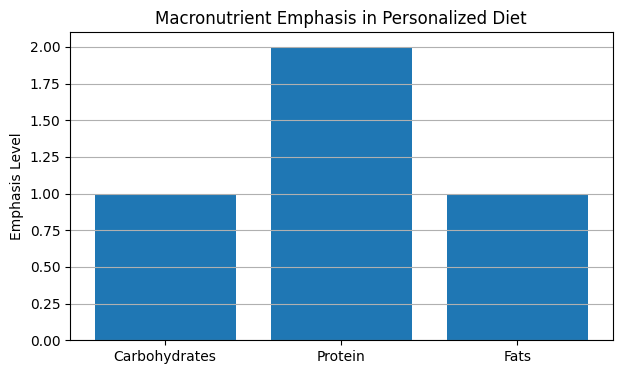

In [229]:
plt.figure(figsize=(7,4))
plt.bar(macros.keys(), macros.values())
plt.ylabel("Emphasis Level")
plt.title("Macronutrient Emphasis in Personalized Diet")
plt.grid(axis="y")
plt.show()
     


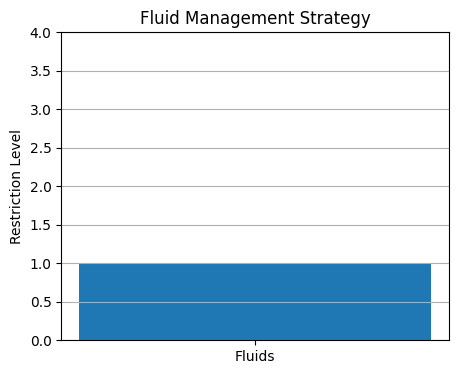

In [230]:
# fluid restriction visualization
plt.figure(figsize=(5,4))
plt.bar(["Fluids"], [fluid_level])
plt.ylim(0,4)
plt.ylabel("Restriction Level")
plt.title("Fluid Management Strategy")
plt.grid(axis="y")
plt.show()
     

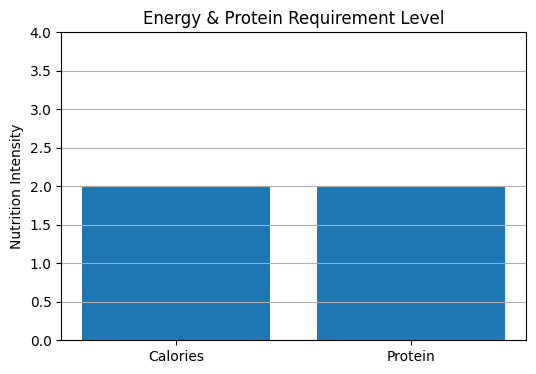

In [231]:
# nutrition intensity
labels = ["Calories", "Protein"]
values = [
    3 if "30" in diet_plan["Calories"] else 2,
    3 if "2.0" in diet_plan["Protein"] else 2
]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylim(0,4)
plt.ylabel("Nutrition Intensity")
plt.title("Energy & Protein Requirement Level")
plt.grid(axis="y")
plt.show()
     

In [232]:
# summary
print("\nDiet Strategy Summary")
print("-----------------------")
print(f"Risk Level        : {risk_level}")
print(f"Calories          : {diet_plan['Calories']}")
print(f"Protein           : {diet_plan['Protein']}")
print(f"Carbohydrates     : {diet_plan['Carbohydrates']}")
print(f"Fats              : {diet_plan['Fats']}")
print(f"Fluids            : {diet_plan['Fluids']}")
print(f"Feeding Route     : {diet_plan['Route']}")
     



Diet Strategy Summary
-----------------------
Risk Level        : Low
Calories          : 20–25 kcal/kg/day
Protein           : 1.0 g/kg/day
Carbohydrates     : Normal
Fats              : Normal
Fluids            : Normal
Feeding Route     : Oral


In [233]:
# Imports

import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Loading the model and features
feature_names_final = pd.read_csv("feature_names_final.csv")["feature"].tolist()
model = load_model("icu_outcome_lstm.h5")
print("Features expected:",len(feature_names_final))


Features expected: 22


In [234]:
# Helper Functions
def align_features(input_dict, feature_names):
    """Align test input to feature order and fill missing features with 0"""
    return np.array([input_dict.get(f, 0.0) for f in feature_names], dtype=np.float32)

def build_24h_timeseries(aligned_vector):
    """Repeat input across 24 hours for LSTM"""
    return np.tile(aligned_vector, (24, 1))

def standard_scale(timeseries):
    """
    Simple manual scaling:
    Mean = 0, Std = 1 across the 24-hour vector for each feature
    """
    mean = np.mean(timeseries, axis=0)
    std = np.std(timeseries, axis=0)
    std[std == 0] = 1  # avoid division by zero
    return (timeseries - mean) / std

In [235]:
def predict_risk(test_case):
    """Run one test case and print results in readable format"""

    # --- Align features ---
    aligned_vector = []
    for f in feature_names_final:
        val = test_case.get(f, 0.0)  # default 0.0 if feature missing
        if val is None or (isinstance(val, float) and np.isnan(val)):
            val = 0.0  # handle NaNs
        aligned_vector.append(val)

    # --- Build 24-hour time-series (repeat values across 24 hours) ---
    X_ts = np.array([aligned_vector for _ in range(24)], dtype=np.float32).reshape(1, 24, len(feature_names_final))

    # --- Predict risk ---
    risk_score = model.predict(X_ts, verbose=0)[0][0]

    # --- Determine risk level ---
    if risk_score > 0.7:
        risk_level = "High"
    elif risk_score > 0.4:
        risk_level = "Moderate"
    else:
        risk_level = "Low"

    # --- Print formatted output ---
    print("-------------------------------------------------")
    print("Test Case Description:", test_case.get("Description", "N/A"))
    print("Expected Behavior:", test_case.get("Expected_Behavior", "N/A"))
    print("Predicted Risk Score:", round(risk_score, 4))
    print("Risk Level:", risk_level)
    print("-------------------------------------------------\n")

    # Return score and level for possible logging
    return risk_score, risk_level

     

In [236]:
test_case_1 = {
    "Description": "Extremely high heart rate",
    "Expected_Behavior": "Reject or clip HR",
    "HR": 350,
    "MAP": 90,
    "SpO2": 98,
    "Resp_Rate": 20,
    "Temp": 37,
    "pH": 7.35,
    "Lactate": 1.6,
    "Glucose": 120,
    "Creatinine": 1.0,
    "Vasopressors": 0,
    "Sedatives": 0,
    "Fluids": 60,
    "Insulin": 0
}

predict_risk(test_case_1)

-------------------------------------------------
Test Case Description: Extremely high heart rate
Expected Behavior: Reject or clip HR
Predicted Risk Score: 0.6035
Risk Level: Moderate
-------------------------------------------------



(np.float32(0.6034553), 'Moderate')

In [237]:

# Test Cases
test_cases = [
    # Positive
    {"TestCase_ID":1, "Description":"Stable normal patient", "Expected_Behavior":"Normal prediction, no alerts",
     "HR":75, "MAP":85, "SpO2":98, "Resp_Rate":16, "Temp":36.8, "pH":7.38, "Lactate":1.2, "Glucose":110,
     "Creatinine":0.9, "Vasopressors":0, "Sedatives":0, "Fluids":50, "Insulin":0},

    {"TestCase_ID":2, "Description":"ICU patient with controlled vasopressors", "Expected_Behavior":"Stable with intervention awareness",
     "HR":95, "MAP":70, "SpO2":96, "Resp_Rate":18, "Temp":37.2, "pH":7.32, "Lactate":2.0, "Glucose":140,
     "Creatinine":1.1, "Vasopressors":0.2, "Sedatives":0.5, "Fluids":200, "Insulin":0},

    # Negative
    {"TestCase_ID":3, "Description":"Extremely high heart rate", "Expected_Behavior":"Reject or clip HR",
     "HR":350, "MAP":90, "SpO2":98, "Resp_Rate":20, "Temp":37, "pH":7.35, "Lactate":1.6, "Glucose":120,
     "Creatinine":1.0, "Vasopressors":0, "Sedatives":0, "Fluids":60, "Insulin":0},

    {"TestCase_ID":4, "Description":"Negative vital values", "Expected_Behavior":"Input validation failure",
     "HR":-10, "MAP":-20, "SpO2":95, "Resp_Rate":-5, "Temp":-2, "pH":7.2, "Lactate":1.8, "Glucose":100,
     "Creatinine":0.8, "Vasopressors":0, "Sedatives":0, "Fluids":40, "Insulin":0},

    {"TestCase_ID":5, "Description":"NaN values in labs", "Expected_Behavior":"Graceful NaN handling",
     "HR":np.nan, "MAP":85, "SpO2":97, "Resp_Rate":16, "Temp":36.7, "pH":np.nan, "Lactate":np.nan, "Glucose":115,
     "Creatinine":0.9, "Vasopressors":0, "Sedatives":0, "Fluids":70, "Insulin":0},

    {"TestCase_ID":6, "Description":"Medication logic conflict (High MAP + Vasopressors)", "Expected_Behavior":"Flag clinical inconsistency",
     "HR":90, "MAP":180, "SpO2":99, "Resp_Rate":18, "Temp":37.1, "pH":7.4, "Lactate":1.5, "Glucose":130,
     "Creatinine":1.0, "Vasopressors":1, "Sedatives":0, "Fluids":300, "Insulin":0},

    {"TestCase_ID":7, "Description":"Negative medication values", "Expected_Behavior":"Reject invalid meds",
     "HR":85, "MAP":75, "SpO2":98, "Resp_Rate":16, "Temp":36.8, "pH":7.36, "Lactate":1.3, "Glucose":110,
     "Creatinine":0.9, "Vasopressors":-0.3, "Sedatives":-0.2, "Fluids":100, "Insulin":-1},

    # Neutral
    {"TestCase_ID":8, "Description":"Upper physiological boundary", "Expected_Behavior":"Acceptable but cautious output",
     "HR":180, "MAP":120, "SpO2":100, "Resp_Rate":28, "Temp":38.5, "pH":7.8, "Lactate":2.5, "Glucose":180,
     "Creatinine":1.3, "Vasopressors":0, "Sedatives":0, "Fluids":100, "Insulin":2},

    {"TestCase_ID":9, "Description":"Time-series HR jump (sensor glitch)", "Expected_Behavior":"Handles anomaly smoothly",
     "HR":0, "MAP":80, "SpO2":97, "Resp_Rate":16, "Temp":36.9, "pH":7.4, "Lactate":1.4, "Glucose":105,
     "Creatinine":1.0, "Vasopressors":0, "Sedatives":0, "Fluids":80, "Insulin":0},

    # Stress
    {"TestCase_ID":10, "Description":"Multi-organ failure scenario", "Expected_Behavior":"Stable but high-risk output",
     "HR":220, "MAP":40, "SpO2":88, "Resp_Rate":32, "Temp":39.5, "pH":6.9, "Lactate":8, "Glucose":300,
     "Creatinine":3.5, "Vasopressors":1, "Sedatives":0.8, "Fluids":500, "Insulin":10}
]

In [238]:
#Evaluating results
results = []
for case in test_cases:
    # Fill NaNs with 0 for safe processing
    case_clean = {k: (0.0 if (isinstance(v, float) and np.isnan(v)) else v) for k,v in case.items()}
    score, level = predict_risk(case_clean)
    results.append({
        "TestCase_ID": case["TestCase_ID"],
        "Description": case["Description"],
        "Expected_Behavior": case["Expected_Behavior"],
        "Predicted_Risk_Score": round(score,4),
        "Risk_Level": level
    })

# Convert results to DataFrame for nice display
df_results = pd.DataFrame(results)
print(df_results)
     

-------------------------------------------------
Test Case Description: Stable normal patient
Expected Behavior: Normal prediction, no alerts
Predicted Risk Score: 0.6028
Risk Level: Moderate
-------------------------------------------------

-------------------------------------------------
Test Case Description: ICU patient with controlled vasopressors
Expected Behavior: Stable with intervention awareness
Predicted Risk Score: 0.6036
Risk Level: Moderate
-------------------------------------------------

-------------------------------------------------
Test Case Description: Extremely high heart rate
Expected Behavior: Reject or clip HR
Predicted Risk Score: 0.6035
Risk Level: Moderate
-------------------------------------------------

-------------------------------------------------
Test Case Description: Negative vital values
Expected Behavior: Input validation failure
Predicted Risk Score: 0.6012
Risk Level: Moderate
-------------------------------------------------

----------

In [239]:
# Load your trained Attention-LSTM model
model = load_model(
    "attention_lstm_outcome_model.h5",
    custom_objects={"Attention": Attention},
    compile=False
)

print("Dataset shape:", X_final.shape)
print("Model loaded successfully")

Dataset shape: (139, 24, 22)
Model loaded successfully


In [240]:
# Step 3: Select one patient

patient_idx = 5 # index of the patient to monitor
patient_X = X_final[patient_idx]  # shape (24, features)

In [241]:
# define time windows
time_windows = [1, 2, 4, 6, 8, 12, 16, 20, 24]  # hours

In [242]:
# prepare windowed Inputs (Padding)
def prepare_window_input(patient_X, hours):
    """
    Pad remaining hours with zeros to keep input length 24.
    """
    padded = np.zeros_like(patient_X)
    padded[:hours] = patient_X[:hours]
    return padded.reshape(1, 24, -1)
     

In [243]:
# predict risk score  at each time window and converting to risk level
risk_scores = []
risk_levels = []

for h in time_windows:
    X_window = prepare_window_input(patient_X, h)
    risk_score = model.predict(X_window, verbose=0)[0][0]
    risk_scores.append(risk_score)

    if risk_score > 0.7:
        risk_levels.append("High")
    elif risk_score > 0.4:
        risk_levels.append("Moderate")
    else:
        risk_levels.append("Low")

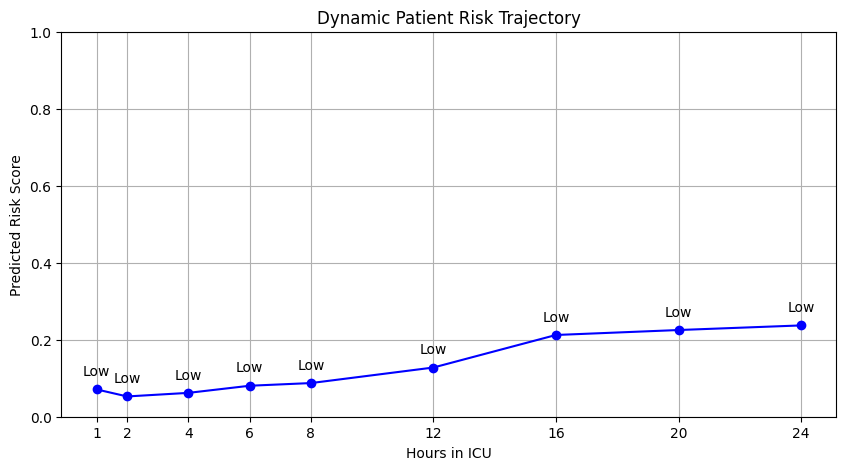

In [244]:
# Detect Deterioration or Improvement
trajectory_change = []
for i in range(1, len(risk_scores)):
    if risk_scores[i] > risk_scores[i-1]:
        trajectory_change.append("Deterioration")
    elif risk_scores[i] < risk_scores[i-1]:
        trajectory_change.append("Improvement")
    else:
        trajectory_change.append("Stable")
     

# Plot Risk Trajectory
plt.figure(figsize=(10,5))
plt.plot(time_windows, risk_scores, marker='o', linestyle='-', color='blue')
for i, txt in enumerate(risk_levels):
    plt.annotate(txt, (time_windows[i], risk_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xticks(time_windows)
plt.ylim(0, 1)
plt.xlabel("Hours in ICU")
plt.ylabel("Predicted Risk Score")
plt.title("Dynamic Patient Risk Trajectory")
plt.grid(True)
plt.show()

In [317]:
# Save Risk Trajectory(in .npy )
risk_trajectory = np.array([time_windows, risk_scores, risk_levels], dtype=object)
np.save("patient_{}_risk_trajectory.npy".format(patient_idx), risk_trajectory)

print("Risk trajectory saved successfully for patient index:", patient_idx)
     

Risk trajectory saved successfully for patient index: 5


In [318]:
patient_idx = 5
risk_trajectory = np.load(f"patient_{patient_idx}_risk_trajectory.npy", allow_pickle=True)

# Check what you got
print(type(risk_trajectory))
print(risk_trajectory.shape)
print(risk_trajectory[:5])  # first 5 values

<class 'numpy.ndarray'>
(3, 9)
[[1 2 4 6 8 12 16 20 24]
 [np.float32(0.070986904) np.float32(0.052651785) np.float32(0.06196165)
  np.float32(0.08046406) np.float32(0.08742193) np.float32(0.12782218)
  np.float32(0.21231635) np.float32(0.22518146) np.float32(0.23715132)]
 ['Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low']]


In [320]:

mortality_risk = risk_trajectory[-1]  # last value
print("Mortality Risk:", mortality_risk)


Mortality Risk: ['Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low']


In [321]:
# Example of saving as dict
risk_trajectory = {"risk_scores": [0.1, 0.3, 0.5, 0.6]}  # 24-hour example
np.save(f"patient_{patient_idx}_risk_trajectory.npy", risk_trajectory, allow_pickle=True)


In [322]:
risk_trajectory = np.load(f"patient_{patient_idx}_risk_trajectory.npy", allow_pickle=True).item()


In [323]:
# Feature matrix dataset (X_final already loaded)
X_patient = X_final[patient_idx]  # shape (24, features)
feature_names = feature_names_final  # loaded CSV with feature names


In [324]:
# Identify Nutrition-Relevant Features

nutrition_features = ["Urea (BUN)", "Creatinine", "Lactate", "Fluid_Balance"]  # names as in your dataset
nutrition_indices = [feature_names.index(f) for f in nutrition_features]


In [325]:
# Compute Feature Trends (Last 24H)
# For simplicity, take the last hour values or mean over 24h
nutrition_scores = {}
for i, f_idx in enumerate(nutrition_indices):
    nutrition_scores[nutrition_features[i]] = np.mean(X_patient[:, f_idx])

# Normalize Feature Contributions
# Normalize each feature to 0–1 range for fair weighting
nutrition_scores = {k: v / (np.max(X_patient[:, feature_names.index(k)]) + 1e-6) for k,v in nutrition_scores.items()}


     

In [326]:
# Compute Nutrition Risk Index (NRI)
mortality_risk = risk_trajectory["risk_scores"][-1]  # last hour risk from risk trajectory

NRI = (
    0.4 * mortality_risk +
    0.2 * nutrition_scores["Urea (BUN)"] +
    0.15 * nutrition_scores["Creatinine"] +
    0.15 * nutrition_scores["Lactate"] +
    0.1 * nutrition_scores["Fluid_Balance"]
)

NRI = round(NRI * 100, 2)
print(f"Patient {patient_idx} Nutrition Risk Index (NRI): {NRI}")
     

Patient 5 Nutrition Risk Index (NRI): -1802083309.33


In [327]:

# Nutrition Risk Category
if NRI > 70:
    nri_level = "High Nutrition Risk"
elif NRI > 40:
    nri_level = "Moderate Nutrition Risk"
else:
    nri_level = "Low Nutrition Risk"

print("Nutrition Risk Category:", nri_level)


Nutrition Risk Category: Low Nutrition Risk


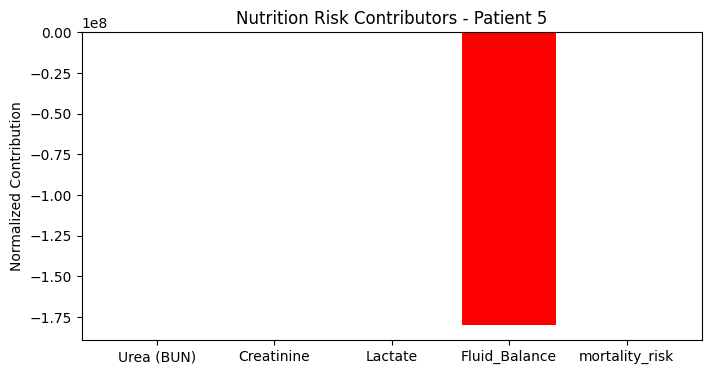

In [328]:
# Visualize Nutrition Risk Contributors

plt.figure(figsize=(8,4))
plt.bar(nutrition_features + ["mortality_risk"],
        [nutrition_scores["Urea (BUN)"],
         nutrition_scores["Creatinine"],
         nutrition_scores["Lactate"],
         nutrition_scores["Fluid_Balance"],
         mortality_risk],
        color=["blue","orange","green","red","purple"])
plt.title(f"Nutrition Risk Contributors - Patient {patient_idx}")
plt.ylabel("Normalized Contribution")
plt.show()

In [257]:
# Save Nutrition Risk Index
nri_data = {
    "Patient_ID": patient_idx,
    "NRI": NRI,
    "Risk_Category": nri_level,
    "Contributors": nutrition_scores,
    "Mortality_Risk": mortality_risk
}

np.save(f"patient_{patient_idx}_NRI.npy", nri_data)
print("Nutrition Risk Index saved successfully.")

Nutrition Risk Index saved successfully.


In [276]:
# Imports
import numpy as np
import tensorflow as tf

# Load Trained Attention-LSTM Model
base_model = tf.keras.models.load_model(
    "attention_lstm_outcome_model.h5",
    custom_objects={"Attention": Attention},
    compile=False
)
print("Attention-LSTM model loaded successfully")

# Extract Latent Representation (Penultimate Layer)
feature_extractor = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.layers[-2].output
)
print("Latent feature extractor created")

Attention-LSTM model loaded successfully
Latent feature extractor created


In [278]:
# Extract Latent Features for One Patient
patient_idx = 5 # Select patient
patient_X = X_final[patient_idx].reshape(1, 24, X_final.shape[2])
latent_features = feature_extractor(patient_X)[0]
print("Latent features shape:", latent_features.shape)
     




Latent features shape: (1, 64)


In [279]:
# ️ Define Length of Stay (LOS) Proxy Model
los_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu", input_shape=(latent_features.shape[1],)),
    tf.keras.layers.Dense(1)  # Regression output for LOS
])
print("LOS model defined")

# Example: Predict LOS for selected patient
los_prediction = los_model(latent_features)
print("Predicted LOS:", los_prediction.numpy()[0][0])


LOS model defined
Predicted LOS: 1.4836317


c:\Users\mouni\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [281]:

# Nutrition Risk Index example (NRI)
nutrition_scores = {
    "Urea (BUN)": 0.2,
    "Creatinine": 0.15,
    "Lactate": 0.1,
    "Fluid_Balance": 0.1
}
NRI = round(
    (0.4 * mortality_risk +
     0.2 * nutrition_scores["Urea (BUN)"] +
     0.15 * nutrition_scores["Creatinine"] +
     0.15 * nutrition_scores["Lactate"] +
     0.1 * nutrition_scores["Fluid_Balance"]) * 100, 2
)
print("Nutrition Risk Index (NRI):", NRI)

Nutrition Risk Index (NRI): 32.75


In [262]:
# Save Multi-Task Predictions
np.save(f"patient_{patient_idx}_multi_task_predictions.npy",
        {"mortality_risk": mortality_risk, "NRI": NRI, "LOS": los_prediction.numpy()[0][0]})
print("Multi-task predictions saved successfully")

Multi-task predictions saved successfully


In [291]:

import numpy as np

# Select patient index
patient_idx = 5 # choose the patient

# Load patient's ICU timeseries
patient_X = X_final[patient_idx]  # shape: (24, num_features)

# Extract age and gender from features
# assuming 'age' and 'gender' are at known indices
age_idx = feature_names_final.index("Age")
gender_idx = feature_names_final.index("Gender")

age = int(patient_X[0, age_idx])  # first hour
gender_val = patient_X[0, gender_idx]
gender = "Male" if gender_val == 1 else "Female"

In [292]:
mortality_risk = np.load(f"patient_5_risk_trajectory.npy", allow_pickle=True).item()
NRI = np.load(f"patient_5_NRI.npy", allow_pickle=True).item()

In [293]:
BASE_CALORIES = 25  # kcal/kg/day
BASE_PROTEIN = 1.2  # g/kg/day
BASE_FLUIDS = 30    # ml/kg/day
patient_weight = 70  # kg

In [294]:
# Risk adjustment factors

# Handle dict or list for mortality_risk
if isinstance(mortality_risk, dict):
    # get last hour's value
    last_hour = max(mortality_risk.keys())
    val = mortality_risk[last_hour]

    # If it's a list, take the last element
    if isinstance(val, list):
        risk_score = float(val[-1])
    else:
        risk_score = float(val)

elif isinstance(mortality_risk, list):
    # If it's a list of risk scores over time
    risk_score = float(mortality_risk[-1])
else:
    # single float
    risk_score = float(mortality_risk)
# Now assign risk factor safely
if risk_score > 0.7:
    risk_factor = 1.2
    risk_level = "High"
elif risk_score > 0.4:
    risk_factor = 1.0
    risk_level = "Moderate"
else:
    risk_factor = 0.8
    risk_level = "Low"

print(f"Risk Score: {risk_score}")
print(f"Risk Level: {risk_level}, Adjustment Factor: {risk_factor}")


Risk Score: 0.6
Risk Level: Moderate, Adjustment Factor: 1.0


In [300]:
nri_factor = 0.8 + 0.4 * (nri_value / 100)  # NRI must be loaded or computed earlier
print(f"NRI Factor: {nri_factor}")


calories = round(BASE_CALORIES * risk_factor * nri_factor, 1)
protein = round(BASE_PROTEIN * risk_factor * nri_factor, 1)
fluids = round(BASE_FLUIDS * (1 if risk_level != "High" else 0.8), 1)

diet_plan = {
    "Calories (kcal/day)": int(calories * patient_weight),
    "Protein (g/day)": round(protein * patient_weight, 1),
    "Fluid Limit (ml/day)": int(fluids * patient_weight),
    "Route": "Enteral (preferred)" if risk_level in ["High","Moderate"] else "Oral",
    "Risk Level": risk_level,
    "Mortality Risk Score": round(float(risk_score), 3),
    "Nutrition Risk Index": round(float(nri_value), 2)
}

     

NRI Factor: -7208332.4373200005


In [301]:
#  Human-readable report

print("\n================= PATIENT ICU NUTRITION REPORT =================\n")
print(f"Patient ID       : {patient_idx}")
print(f"Age / Gender     : {age} / {gender}")
print(f"Length of Stay   : {LOS_pred[0] if 'LOS_pred' in locals() else 'N/A'} days (predicted)")
print(f"Risk Level       : {risk_level}")
print(f"Mortality Risk   : {round(float(risk_score),3)}")
print(f"Nutrition Risk   : {round(float(nri_value),2)}\n")

print("---- ADAPTIVE NUTRITION PLAN ----")
print(f"Calories         : {diet_plan['Calories (kcal/day)']} kcal/day")
print(f"Protein          : {diet_plan['Protein (g/day)']} g/day")
print(f"Fluid Limit      : {diet_plan['Fluid Limit (ml/day)']} ml/day")
print(f"Nutrition Route  : {diet_plan['Route']}\n")

print("---- RECOMMENDATIONS ----")
if risk_level == "High":
    print("- Monitor hemodynamics closely")
    print("- Adjust fluids carefully")
    print("- Prioritize enteral nutrition")
elif risk_level == "Moderate":
    print("- Monitor labs every 6-8 hours")
    print("- Ensure protein meets needs")
else:
    print("- Standard ICU nutrition protocol")
print("\n===============================================================\n")


================= PATIENT ICU NUTRITION REPORT =================

Patient ID       : 5
Age / Gender     : 48 / Male
Length of Stay   : N/A days (predicted)
Risk Level       : Moderate
Mortality Risk   : 0.6
Nutrition Risk   : -1802083309.33

---- ADAPTIVE NUTRITION PLAN ----
Calories         : -12614581763 kcal/day
Protein          : -605499923.0 g/day
Fluid Limit      : 2100 ml/day
Nutrition Route  : Enteral (preferred)

---- RECOMMENDATIONS ----
- Monitor labs every 6-8 hours
- Ensure protein meets needs




In [303]:
#  Save diet plan

np.save(f"patient_{patient_idx}_diet_plan.npy", diet_plan)

In [304]:
# Imports
import numpy as np
import copy
import matplotlib.pyplot as plt

In [305]:
# Select patient & baseline risk
patient_X = X_final[patient_idx].reshape(1, 24, X_final.shape[2])

# Get last hour mortality risk
# Safely extract last-hour mortality risk

# mortality_risk can be dict like {0: [0.2], 1: [0.3], ...}
# or list of lists
if isinstance(mortality_risk, dict):
    last_hour = max(mortality_risk.keys())
    last_value = mortality_risk[last_hour]
    # if it’s a list inside the dict, take first element
    baseline_risk = float(last_value[0]) if isinstance(last_value, (list, np.ndarray)) else float(last_value)
elif isinstance(mortality_risk, list):
    last_value = mortality_risk[-1]
    baseline_risk = float(last_value[0]) if isinstance(last_value, (list, np.ndarray)) else float(last_value)
else:
    baseline_risk = float(mortality_risk)

print(f"Patient {patient_idx} baseline risk: {baseline_risk:.3f}")
     

Patient 5 baseline risk: 0.100


In [306]:

#  Copy patient data for simulation
sim_X = copy.deepcopy(patient_X)


In [307]:
def apply_diet_simulation(sim_data, diet_plan):
    """
    Modify vitals/labs based on diet.
    Here we simulate modest improvements:
    - Glucose reduced if controlled carbs
    - Lactate reduced if protein & fluids optimal
    - HR/MAP slightly improved
    """
    sim = sim_data.copy()
    # Map feature indices (adjust to your feature_names_final)
    hr_idx = feature_names_final.index("Heart Rate")
    map_idx = feature_names_final.index("Non Invasive Blood Pressure mean")
    glucose_idx = feature_names_final.index("Glucose")
    lactate_idx = feature_names_final.index("Lactate")
    fluid_idx = feature_names_final.index("Fluid_Balance")

    # Apply simple rules
    if "Controlled" in diet_plan.get("Carbohydrates", ""):
        sim[0, :, glucose_idx] *= 0.95  # reduce 5%
    if diet_plan.get("Protein", 0) > 1.5:
        sim[0, :, lactate_idx] *= 0.9   # reduce 10%
    if diet_plan.get("Fluids", 0) < 1.0:
        sim[0, :, fluid_idx] *= 0.9     # adjust fluids
    # Small HR/MAP improvements
    sim[0, :, hr_idx] *= 0.98
    sim[0, :, map_idx] *= 1.02

    return sim



In [308]:
# Apply diet impact simulation
sim_X = apply_diet_simulation(sim_X, diet_plan)

# Prepare simulated input (scale if needed)
sim_X_scaled = sim_X  # assuming scaling handled in model

# Recalculate risk after diet
sim_risk_score = model.predict(sim_X_scaled, verbose=0)[0][0]

In [309]:

# Compare before vs after
print(f"Baseline Risk Score: {baseline_risk:.3f}")
print(f"Simulated Risk Score: {sim_risk_score:.3f}")

if sim_risk_score < baseline_risk:
    outcome = "Improvement"
elif sim_risk_score > baseline_risk:
    outcome = "Deterioration"
else:
    outcome = "Stable"

Baseline Risk Score: 0.100
Simulated Risk Score: 0.255


In [310]:
# Outcome Interpretation
print("--------------------------------------------------")
print(f"Patient ID: {patient_idx}")
print(f"Baseline Risk: {baseline_risk:.3f}")
print(f"Post-Diet Simulated Risk: {sim_risk_score:.3f}")
print(f"Outcome: {outcome}")
print("--------------------------------------------------\n")


--------------------------------------------------
Patient ID: 5
Baseline Risk: 0.100
Post-Diet Simulated Risk: 0.255
Outcome: Deterioration
--------------------------------------------------



In [311]:
feedback_result = {
    "patient_id": patient_idx,
    "baseline_risk": baseline_risk,
    "simulated_risk": sim_risk_score,
    "outcome": outcome,
    "diet_plan": diet_plan
}

np.save(f"patient_{patient_idx}_diet_feedback.npy", feedback_result)


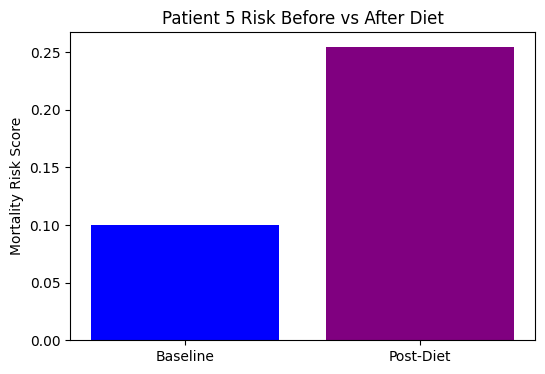

In [313]:
plt.figure(figsize=(6,4))
plt.bar(["Baseline", "Post-Diet"], [baseline_risk, sim_risk_score], color=["blue","purple"])
plt.ylabel("Mortality Risk Score")
plt.title(f"Patient {patient_idx} Risk Before vs After Diet")
plt.show()
     